In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import torch

DATASET_NAME = 'CIFAR10'    # CIFAR10, CIFAR100
DATASET_TYPE = 'custom'   # baseline, custom
REWEIGHT = True
EPOCHS = 200
BATCH_SIZE = 128
ENABLE_TPU = True
LEARNING_RATE = 0.1   # 0.15(default), 0.1
MANUAL_SEED = 4

# CIFAR-10-C
if DATASET_NAME=='CIFAR10':
    dataset_dir = '/kaggle/input/cifar-c'
    print(os.listdir(dataset_dir))
    # Define the path to the subdirectory
    sub_dir = os.path.join(dataset_dir, 'CIFAR-10-C')
    # List contents of the subdirectory
    print(os.listdir(sub_dir))
elif DATASET_NAME=='CIFAR100':
    # CIFAR-100-C
    dataset_dir = '/kaggle/input/cifar-100-c'
    print(os.listdir(dataset_dir))
else:
    raise ValueError(f'Dataset {DATASET_NAME} not supported')
    

print(f'Hyperparameters:\n\tDataset: {DATASET_NAME}\n\tType: {DATASET_TYPE}\n\tEpochs: {EPOCHS}\n\tTPU Enabled: {ENABLE_TPU}')

['CIFAR-10-C']
['motion_blur.npy', 'speckle_noise.npy', 'jpeg_compression.npy', 'impulse_noise.npy', 'defocus_blur.npy', 'brightness.npy', 'elastic_transform.npy', 'snow.npy', 'labels.npy', 'gaussian_blur.npy', 'frost.npy', 'zoom_blur.npy', 'spatter.npy', 'fog.npy', 'gaussian_noise.npy', 'contrast.npy', 'saturate.npy', 'shot_noise.npy', 'pixelate.npy', 'glass_blur.npy']
Hyperparameters:
	Dataset: CIFAR10
	Type: custom
	Epochs: 200
	TPU Enabled: True


In [2]:
!pip install torchmetrics
!git clone https://github.com/EkagraGupta/MasterArbeit.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/926.4 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 921.6/926.4 kB 14.7 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 11.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Cloning into 'MasterArbeit'...


remote: Enumerating objects: 3584, done.


remote: Counting objects: 100% (398/398), done.


remote: Compressing objects: 100% (222/222), done.


remote: Total 3584 (delta 232), reused 335 (delta 176), pack-reused 3186 (from 1)
Receiving objects: 100% (3584/3584), 1.10 GiB | 34.41 MiB/s, done.


Resolving deltas: 100% (1987/1987), done.


Updating files: 100% (295/295), done.


In [3]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(MANUAL_SEED)

In [4]:
# Import statements
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import TrivialAugmentWide
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
import os

# Define the device
tpu = ENABLE_TPU

if tpu == True:
    print('TPU is Enabled')
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
else:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  #intend here for else


class CustomDataset(Dataset):
    def __init__(self, np_images, original_dataset, resize):
        # Load images
        self.images = torch.from_numpy(np_images).permute(0, 3, 1, 2) / 255
         #Normalize the images
        #transform_test = transforms.Compose([
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        #])
        #self.images = transform_test(self.images)
        #if resize == True:
            #self.images = transforms.Resize(224, antialias=True)(self.images)
        
        # Extract labels from the original PyTorch dataset
        self.labels = [label for _, label in original_dataset]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Get image and label for the given index
        image = self.images[index]
        label = self.labels[index]

        return image, label

# Define the function to load corrupted datasets separately
def load_data_c_separately(dataset, testset, resize, test_transforms, batch_size):
    corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']
    np.asarray(corruptions)
    c_datasets = {}
    for corruption in corruptions:
        if dataset == 'CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
            np_data_c = np.array(np.array_split(np_data_c, 5))
            custom_dataset = CustomDataset(np_data_c[0], testset, resize)  # Load only one split for now
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)
            c_datasets[corruption] = custom_dataloader
        else:
            print('No corrupted benchmark available other than CIFAR10-c.')

    return c_datasets


# Load corrupted datasets
#corrupted_datasets = load_data_c(dataset='CIFAR10', testset=testset, resize=True, 
                                 #test_transforms=None, subset=False, subsetsize=None)

# Transformations for training and test sets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),  
    TrivialAugmentWide(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = BATCH_SIZE

print(f'Loading {DATASET_NAME}...\n')
if DATASET_NAME=='CIFAR10':
#     Use CIFAR-10 dataset for training
    num_classes = 10    # CIFAR-10
    baseline_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
    baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)

    # Use CIFAR-10 dataset for testing
    baseline_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)
elif DATASET_NAME=='CIFAR100':
    # # Use CIFAR-100 dataset for training
    num_classes = 100   # CIFAR-100
    baseline_trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform_train)
    baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)

    # Use CIFAR-100 dataset for testing
    baseline_testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform_test)
    baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)
    
%cd /kaggle/working/MasterArbeit
from augment_dataset import create_transforms, load_data
# from compute_loss import soft_loss

"""
 Create the transformations based on the provided flags:
 - If all flags (random_cropping, aggressive_augmentation, and custom) are False:
   No augmentation other than default preprocessing is applied.
 - If random_cropping (rc) is True and the others (aa and custom) are False:
   Only random cropping is applied.
 - If random_cropping (rc) and aggressive_augmentation (aa) are True, and custom is False:
   Random cropping and conventional aggressive augmentation techniques (TA) are applied.
 - If all three flags (rc, aa, custom) are True:
   Random cropping and soft augmentation techniques (TA) are applied.
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is False:
   Only conventional aggressive augmentation techniques (TA) are applied (no soft labels).
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is True:
   Aggressive augmentation (TA) is applied with soft labeling.
"""

transforms_preprocess, transforms_augmentation = create_transforms(random_cropping=False, aggressive_augmentation=True, custom=True, dataset_name=DATASET_NAME)
custom_trainset, custom_testset = load_data(transforms_preprocess=transforms_preprocess, transforms_augmentation=transforms_augmentation, dataset_name=DATASET_NAME)
custom_trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)
custom_testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)
%cd

classes = baseline_trainset.classes


TPU is Enabled


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


E0000 00:00:1731830982.364780      77 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:483


Loading CIFAR10...



  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 65536/170498071 [00:00<07:48, 363752.93it/s]

  0%|          | 229376/170498071 [00:00<04:09, 681167.82it/s]

  1%|          | 917504/170498071 [00:00<01:20, 2097617.41it/s]

  1%|▏         | 2392064/170498071 [00:00<00:30, 5429695.60it/s]

  3%|▎         | 5668864/170498071 [00:00<00:12, 12900714.54it/s]

  5%|▌         | 8814592/170498071 [00:00<00:08, 18110865.26it/s]

  7%|▋         | 12386304/170498071 [00:00<00:06, 23140447.66it/s]

  9%|▉         | 16154624/170498071 [00:01<00:05, 27338614.64it/s]

 11%|█▏        | 19300352/170498071 [00:01<00:05, 25684536.91it/s]

 13%|█▎        | 22872064/170498071 [00:01<00:05, 28108899.81it/s]

 15%|█▌        | 26247168/170498071 [00:01<00:04, 29637454.50it/s]

 17%|█▋        | 29556736/170498071 [00:01<00:04, 30409933.44it/s]

 19%|█▉        | 32931840/170498071 [00:01<00:04, 31366806.26it/s]

 22%|██▏       | 36667392/170498071 [00:01<00:04, 33109768.24it/s]

 24%|██▎       | 40435712/170498071 [00:01<00:03, 34431083.79it/s]

 26%|██▌       | 43941888/170498071 [00:01<00:03, 34172061.87it/s]

 28%|██▊       | 47415296/170498071 [00:02<00:03, 33019983.94it/s]

 30%|██▉       | 50855936/170498071 [00:02<00:03, 33363584.82it/s]

 32%|███▏      | 54231040/170498071 [00:02<00:03, 33392198.21it/s]

 34%|███▍      | 57606144/170498071 [00:02<00:03, 30355789.76it/s]

 36%|███▌      | 61341696/170498071 [00:02<00:03, 32278208.61it/s]

 38%|███▊      | 65110016/170498071 [00:02<00:03, 33779785.96it/s]

 40%|████      | 68550656/170498071 [00:02<00:03, 33565326.37it/s]

 42%|████▏     | 72318976/170498071 [00:02<00:02, 34728849.95it/s]

 45%|████▍     | 75890688/170498071 [00:02<00:02, 35008760.56it/s]

 47%|████▋     | 79429632/170498071 [00:02<00:02, 30704306.40it/s]

 49%|████▊     | 82837504/170498071 [00:03<00:02, 31609671.93it/s]

 51%|█████     | 86147072/170498071 [00:03<00:02, 32010660.79it/s]

 53%|█████▎    | 89620480/170498071 [00:03<00:02, 32774474.22it/s]

 55%|█████▍    | 93323264/170498071 [00:03<00:02, 33994860.80it/s]

 57%|█████▋    | 97058816/170498071 [00:03<00:02, 34969750.78it/s]

 59%|█████▉    | 100597760/170498071 [00:03<00:02, 34667732.04it/s]

 61%|██████    | 104103936/170498071 [00:03<00:02, 32734549.64it/s]

 63%|██████▎   | 107446272/170498071 [00:03<00:01, 32912033.54it/s]

 65%|██████▌   | 110886912/170498071 [00:03<00:01, 33170353.24it/s]

 67%|██████▋   | 114229248/170498071 [00:04<00:01, 31311723.54it/s]

 69%|██████▉   | 117538816/170498071 [00:04<00:01, 31628630.77it/s]

 71%|███████   | 121274368/170498071 [00:04<00:01, 33261253.58it/s]

 73%|███████▎  | 125009920/170498071 [00:04<00:01, 34347536.60it/s]

 75%|███████▌  | 128483328/170498071 [00:04<00:01, 33095425.82it/s]

 77%|███████▋  | 131858432/170498071 [00:04<00:01, 33269044.22it/s]

 80%|███████▉  | 135626752/170498071 [00:04<00:01, 34520296.13it/s]

 82%|████████▏ | 139100160/170498071 [00:04<00:00, 33258247.88it/s]

 84%|████████▎ | 142475264/170498071 [00:04<00:00, 32265721.02it/s]

 86%|████████▌ | 145784832/170498071 [00:04<00:00, 32468995.05it/s]

 87%|████████▋ | 149061632/170498071 [00:05<00:00, 31792821.65it/s]

 90%|████████▉ | 152829952/170498071 [00:05<00:00, 33470117.52it/s]

 92%|█████████▏| 156565504/170498071 [00:05<00:00, 34595670.59it/s]

 94%|█████████▍| 160071680/170498071 [00:05<00:00, 33563808.05it/s]

 96%|█████████▌| 163446784/170498071 [00:05<00:00, 33284183.98it/s]

 98%|█████████▊| 167182336/170498071 [00:05<00:00, 34458340.82it/s]

100%|██████████| 170498071/170498071 [00:05<00:00, 29817007.90it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


Files already downloaded and verified


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/kaggle/working/MasterArbeit


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 65536/170498071 [00:00<07:54, 359560.52it/s]

  0%|          | 229376/170498071 [00:00<04:12, 674816.06it/s]

  1%|          | 917504/170498071 [00:00<01:21, 2079762.96it/s]

  1%|▏         | 2293760/170498071 [00:00<00:32, 5145654.57it/s]

  3%|▎         | 5406720/170498071 [00:00<00:13, 12227911.30it/s]

  5%|▌         | 8552448/170498071 [00:00<00:09, 17593581.78it/s]

  7%|▋         | 12255232/170498071 [00:00<00:06, 23130133.03it/s]

  9%|▉         | 15630336/170498071 [00:01<00:05, 25986565.24it/s]

 11%|█         | 19103744/170498071 [00:01<00:05, 28507404.30it/s]

 13%|█▎        | 22216704/170498071 [00:01<00:05, 27395672.56it/s]

 15%|█▍        | 25559040/170498071 [00:01<00:05, 28841296.63it/s]

 17%|█▋        | 29065216/170498071 [00:01<00:04, 30548119.45it/s]

 19%|█▉        | 32473088/170498071 [00:01<00:04, 30070228.03it/s]

 21%|██        | 35553280/170498071 [00:01<00:04, 29806252.37it/s]

 23%|██▎       | 38895616/170498071 [00:01<00:04, 30826452.35it/s]

 25%|██▍       | 42401792/170498071 [00:01<00:03, 32042841.33it/s]

 27%|██▋       | 45973504/170498071 [00:02<00:03, 33086509.39it/s]

 29%|██▉       | 49348608/170498071 [00:02<00:03, 32492121.15it/s]

 31%|███       | 52985856/170498071 [00:02<00:03, 33605827.66it/s]

 33%|███▎      | 56393728/170498071 [00:02<00:03, 33697981.00it/s]

 35%|███▌      | 59801600/170498071 [00:02<00:03, 33710424.30it/s]

 37%|███▋      | 63209472/170498071 [00:02<00:03, 30825015.97it/s]

 39%|███▉      | 66486272/170498071 [00:02<00:03, 30394142.56it/s]

 41%|████      | 70025216/170498071 [00:02<00:03, 31044628.22it/s]

 43%|████▎     | 73302016/170498071 [00:02<00:03, 31361891.82it/s]

 45%|████▌     | 76906496/170498071 [00:02<00:02, 32692641.87it/s]

 47%|████▋     | 80576512/170498071 [00:03<00:02, 33849600.59it/s]

 49%|████▉     | 83984384/170498071 [00:03<00:02, 33901045.30it/s]

 51%|█████▏    | 87392256/170498071 [00:03<00:02, 32837268.02it/s]

 53%|█████▎    | 90996736/170498071 [00:03<00:02, 33744267.00it/s]

 55%|█████▌    | 94404608/170498071 [00:03<00:02, 33292988.25it/s]

 57%|█████▋    | 97746944/170498071 [00:03<00:02, 33209351.82it/s]

 59%|█████▉    | 101089280/170498071 [00:03<00:02, 32909878.37it/s]

 61%|██████    | 104398848/170498071 [00:03<00:02, 29535309.90it/s]

 63%|██████▎   | 107708416/170498071 [00:03<00:02, 30494827.61it/s]

 65%|██████▌   | 111280128/170498071 [00:04<00:01, 31931230.72it/s]

 67%|██████▋   | 114524160/170498071 [00:04<00:01, 30326212.29it/s]

 69%|██████▉   | 117833728/170498071 [00:04<00:01, 31050481.90it/s]

 71%|███████   | 121110528/170498071 [00:04<00:01, 31393895.32it/s]

 73%|███████▎  | 124321792/170498071 [00:04<00:01, 29763183.96it/s]

 75%|███████▍  | 127860736/170498071 [00:04<00:01, 31271552.81it/s]

 77%|███████▋  | 131203072/170498071 [00:04<00:01, 31815117.84it/s]

 79%|███████▉  | 134414336/170498071 [00:04<00:01, 31839437.38it/s]

 81%|████████  | 137953280/170498071 [00:04<00:00, 32869405.28it/s]

 83%|████████▎ | 141262848/170498071 [00:04<00:00, 31537557.01it/s]

 85%|████████▍ | 144900096/170498071 [00:05<00:00, 32876681.63it/s]

 87%|████████▋ | 148209664/170498071 [00:05<00:00, 32723638.87it/s]

 89%|████████▉ | 151748608/170498071 [00:05<00:00, 33481352.50it/s]

 91%|█████████ | 155123712/170498071 [00:05<00:00, 30134517.54it/s]

 93%|█████████▎| 158236672/170498071 [00:05<00:00, 30358147.14it/s]

 95%|█████████▍| 161775616/170498071 [00:05<00:00, 31766805.29it/s]

 97%|█████████▋| 165019648/170498071 [00:05<00:00, 31323814.96it/s]

 99%|█████████▉| 168624128/170498071 [00:05<00:00, 30615105.51it/s]

100%|██████████| 170498071/170498071 [00:05<00:00, 28765172.47it/s]

Extracting ./data/train/cifar-10-python.tar.gz to ./data/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 65536/170498071 [00:00<07:58, 356049.32it/s]

  0%|          | 229376/170498071 [00:00<04:14, 669717.55it/s]

  1%|          | 917504/170498071 [00:00<01:22, 2065137.04it/s]

  2%|▏         | 2588672/170498071 [00:00<00:28, 5886324.16it/s]

  3%|▎         | 5505024/170498071 [00:00<00:13, 12200329.80it/s]

  5%|▌         | 8978432/170498071 [00:00<00:08, 18487971.30it/s]

  7%|▋         | 12222464/170498071 [00:00<00:07, 22455589.02it/s]

  9%|▉         | 15433728/170498071 [00:01<00:06, 25240402.31it/s]

 11%|█         | 18939904/170498071 [00:01<00:05, 28100757.50it/s]

 13%|█▎        | 22249472/170498071 [00:01<00:05, 29568094.10it/s]

 15%|█▍        | 25427968/170498071 [00:01<00:05, 27668140.88it/s]

 17%|█▋        | 28901376/170498071 [00:01<00:04, 29617700.57it/s]

 19%|█▉        | 32309248/170498071 [00:01<00:04, 30118104.15it/s]

 21%|██        | 35520512/170498071 [00:01<00:04, 30580932.66it/s]

 23%|██▎       | 38830080/170498071 [00:01<00:04, 31045762.50it/s]

 25%|██▍       | 41975808/170498071 [00:01<00:04, 31064214.85it/s]

 27%|██▋       | 45481984/170498071 [00:02<00:03, 32162047.83it/s]

 29%|██▉       | 49119232/170498071 [00:02<00:03, 33333316.58it/s]

 31%|███       | 52592640/170498071 [00:02<00:03, 33460902.04it/s]

 33%|███▎      | 55967744/170498071 [00:02<00:03, 33356859.06it/s]

 35%|███▍      | 59572224/170498071 [00:02<00:03, 34144598.41it/s]

 37%|███▋      | 63078400/170498071 [00:02<00:03, 34409030.60it/s]

 39%|███▉      | 66551808/170498071 [00:02<00:03, 33179751.62it/s]

 41%|████      | 69894144/170498071 [00:02<00:03, 30141882.19it/s]

 43%|████▎     | 72974336/170498071 [00:02<00:03, 30074442.77it/s]

 45%|████▍     | 76611584/170498071 [00:02<00:02, 31807616.13it/s]

 47%|████▋     | 80216064/170498071 [00:03<00:02, 33012090.85it/s]

 49%|████▉     | 83623936/170498071 [00:03<00:02, 33297992.32it/s]

 51%|█████     | 86999040/170498071 [00:03<00:02, 33121857.20it/s]

 53%|█████▎    | 90341376/170498071 [00:03<00:02, 32997343.59it/s]

 55%|█████▌    | 93913088/170498071 [00:03<00:02, 33767504.94it/s]

 57%|█████▋    | 97517568/170498071 [00:03<00:02, 34436130.08it/s]

 59%|█████▉    | 100990976/170498071 [00:03<00:02, 32013499.31it/s]

 61%|██████    | 104235008/170498071 [00:03<00:02, 30118928.76it/s]

 63%|██████▎   | 107511808/170498071 [00:03<00:02, 30829366.13it/s]

 65%|██████▌   | 110952448/170498071 [00:04<00:01, 31820884.16it/s]

 67%|██████▋   | 114491392/170498071 [00:04<00:01, 32831597.85it/s]

 69%|██████▉   | 118063104/170498071 [00:04<00:01, 33659298.33it/s]

 71%|███████▏  | 121536512/170498071 [00:04<00:01, 33842680.60it/s]

 73%|███████▎  | 124944384/170498071 [00:04<00:01, 33139851.39it/s]

 75%|███████▌  | 128450560/170498071 [00:04<00:01, 33638313.23it/s]

 77%|███████▋  | 131956736/170498071 [00:04<00:01, 34048431.68it/s]

 79%|███████▉  | 135397376/170498071 [00:04<00:01, 32569550.55it/s]

 81%|████████▏ | 138674176/170498071 [00:04<00:01, 31373585.85it/s]

 83%|████████▎ | 141950976/170498071 [00:04<00:00, 31746359.59it/s]

 85%|████████▌ | 145227776/170498071 [00:05<00:00, 31613676.23it/s]

 87%|████████▋ | 148439040/170498071 [00:05<00:00, 31618509.97it/s]

 89%|████████▉ | 151617536/170498071 [00:05<00:00, 31647973.10it/s]

 91%|█████████ | 154927104/170498071 [00:05<00:00, 32019188.36it/s]

 93%|█████████▎| 158564352/170498071 [00:05<00:00, 33279078.95it/s]

 95%|█████████▌| 162103296/170498071 [00:05<00:00, 33898743.77it/s]

 97%|█████████▋| 165675008/170498071 [00:05<00:00, 34424746.01it/s]

 99%|█████████▉| 169148416/170498071 [00:05<00:00, 33641871.80it/s]

100%|██████████| 170498071/170498071 [00:05<00:00, 29256955.48it/s]

Extracting ./data/test/cifar-10-python.tar.gz to ./data/test


/root


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:428: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
print(transforms_augmentation)

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=4)
    CustomTrivialAugmentWide(custom=True, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
)


Dataset type "custom" displaying...



cat  : 1.00, 3 airplane: 1.00, 0 horse: 1.00, 7 bird : 1.00, 2 truck: 1.00, 9 frog : 1.00, 6 cat  : 0.97, 3 cat  : 0.87, 3 horse: 0.89, 7 cat  : 0.98, 3 dog  : 0.99, 5 cat  : 0.94, 3 bird : 0.93, 2 automobile: 0.51, 1 bird : 1.00, 2 airplane: 1.00, 0 frog : 1.00, 6 deer : 1.00, 4 cat  : 1.00, 3 ship : 1.00, 8 automobile: 0.98, 1 bird : 1.00, 2 bird : 1.00, 2 airplane: 1.00, 0 bird : 1.00, 2 dog  : 1.00, 5 truck: 0.92, 9 ship : 1.00, 8 automobile: 1.00, 1 automobile: 0.92, 1 frog : 1.00, 6 frog : 0.62, 6 truck: 0.90, 9 cat  : 1.00, 3 bird : 0.78, 2 horse: 0.86, 7 airplane: 1.00, 0 horse: 0.97, 7 frog : 0.71, 6 airplane: 0.86, 0 cat  : 0.99, 3 automobile: 1.00, 1 truck: 1.00, 9 bird : 1.00, 2 cat  : 0.39, 3 cat  : 0.98, 3 truck: 1.00, 9 airplane: 1.00, 0 bird : 0.62, 2 horse: 1.00, 7 deer : 1.00, 4 dog  : 0.99, 5 cat  : 1.00, 3 dog  : 0.97, 5 cat  : 1.00, 3 ship : 1.00, 8 cat  : 1.00, 3 truck: 1.00, 9 horse: 0.51, 7 ship : 1.00, 8 horse: 0.93, 7 dog  : 0.86, 5 airplane: 0.97, 0 dog  : 0.

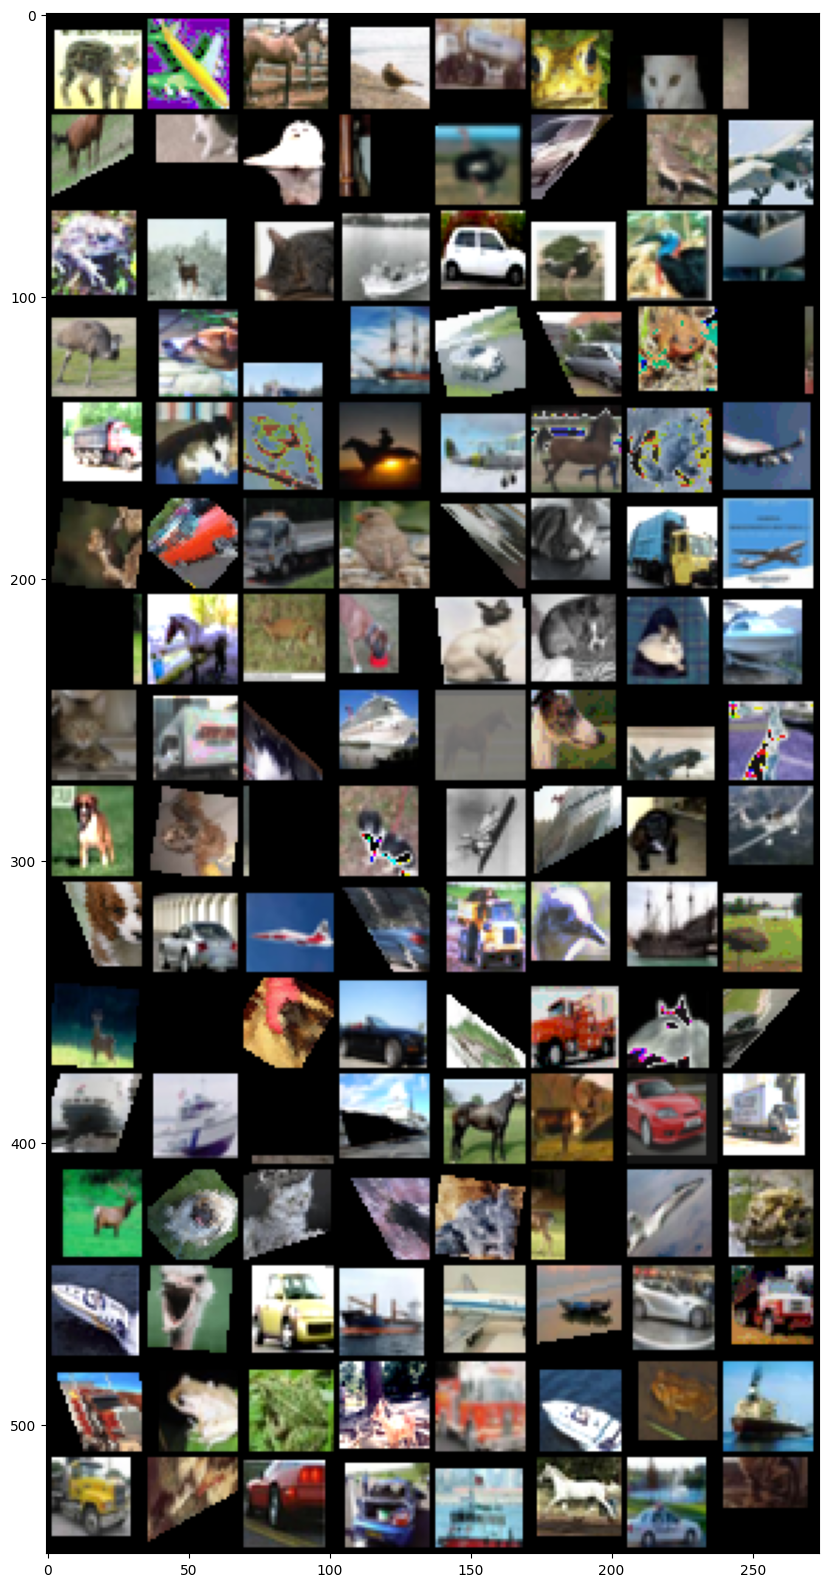

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.cpu().numpy()
    plt.figure(figsize=(25, 20))  # Adjust the width and height as needed
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
print(f'Dataset type "{DATASET_TYPE}" displaying...\n')

if DATASET_TYPE=='custom':
    dataiter = iter(custom_trainloader)
    images, labels, confidences = next(dataiter)
    # print labels 
    if isinstance(confidences, list):
        # in case we have confidence 
        confidences = confidences[1]
        
    print(' '.join(f'{classes[labels[j]]:5s}: {confidences[j].item():.2f}, {labels[j].item()}' for j in range(batch_size)))
elif DATASET_TYPE=='baseline':
#     if training baseline model
    dataiter = iter(baseline_trainloader)
    images, labels = next(dataiter)
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
else:
    raise ValueError(f'Dataset type {DATASET_TYPE} not supported')
    
# show images
imshow(torchvision.utils.make_grid(images))

## Define WideResNet 28_4

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np


# Manual implementation of ResNet18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling layer
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)  # Apply global average pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



# ResNet18 Architecture
def ResNet18(num_classes=num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [8]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform(m.weight, gain=np.sqrt(2))
        init.constant(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant(m.weight, 1)
        init.constant(m.bias, 0)

class WideBasic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(WideBasic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate=0.3, num_classes=num_classes, factor=1, block=WideBasic):
        super(WideResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (int)((depth-4)/6)
        k = widen_factor

        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0], stride=1)
        self.layer1 = self._wide_layer(block, nStages[1], n, dropout_rate, stride=factor)
        self.layer2 = self._wide_layer(block, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(block, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

def WideResNet_28_4(num_classes, factor=1, block=WideBasic, dropout_rate=0.3):
    return WideResNet(depth=28, widen_factor=4, dropout_rate=dropout_rate, num_classes=num_classes, factor=factor, block=block)

## Model Training

In [9]:
# Initialize the model
net = WideResNet_28_4(num_classes=num_classes)
net.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): WideBasic(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): WideBasic(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, ke

In [10]:
def soft_loss(pred, label, confidence, reweight=False):
    log_prob = F.log_softmax(pred, dim=1)
    n_class = pred.size(1)

    # Make soft one-hot target
    label = label.unsqueeze(1)
    confidence = confidence.unsqueeze(1).float()
    # soft one_hot
    one_hot = torch.ones_like(pred) * (1 - confidence) / (n_class - 1)
    one_hot.scatter_(dim=1, index=label, src=confidence)
    
    # hard one_hot
#     one_hot = torch.zeros_like(pred)
#     one_hot.scatter_(dim=1, index=label, value=1.0)
    # Compute weighted KL loss
    kl = F.kl_div(input=log_prob, target=one_hot, reduction="none").sum(-1)
    kl = kl.unsqueeze(1)  # Unweighted
    if reweight:
        kl = confidence * kl  # Weighted
    return kl.mean()

In [11]:
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)

# Initialize the scheduler
epochs = EPOCHS
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # Cosine Annealing LR Scheduler

# For plotting
train_losses, test_accuracies = [], []

# Training loop
print(f'\nStart Training...\n')
for epoch in range(epochs):  # loop over the dataset multiple times
    
    start_time = time.time()
    
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    total = 0
    correct = 0
    confidences = None
    
    net.train()
    
    if DATASET_TYPE=='baseline':
        trainloader = baseline_trainloader
    elif DATASET_TYPE=='custom':
        trainloader = custom_trainloader
    else:
        raise ValueError('Dataset type is not Valid!')
    
    for i, data in enumerate(trainloader):
            
        if DATASET_TYPE=='baseline':
            inputs, labels = data
        elif DATASET_TYPE=='custom':
            inputs, labels, confidences = data
            # get the inputs
            """when the model returns [augmentation_magnitude, confidence_aa], which is the case
            only when TA with soft labels is applied."""
            if isinstance(confidences, list):
                confidences = confidences[1]
            confidences = confidences.to(device)
        else:
            raise ValueError('Dataset type is not Valid!')
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        inputs, labels = inputs.to(device), labels.to(device)
    
        # Convert labels to one-hot encoded vectors
        # labels_one_hot = F.one_hot(labels, num_classes=10).float()
        
        # forward + backward + optimize
        outputs = net(inputs)
        outputs = outputs.to(device)
        
        if DATASET_TYPE=='custom':
            loss = soft_loss(pred=outputs, label=labels, confidence=confidences, reweight=REWEIGHT)
        else:
            loss = criterion(outputs, labels)
        
        # Check for correct training
        if np.isnan(loss.detach().cpu().numpy()):
            raise ValueError('Loss calculation not correct')
    
        loss.backward()
        optimizer.step()
        
        if tpu:
            xm.mark_step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    with torch.no_grad():
        net.eval()
        for images, labels in baseline_testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # calculate and print average loss for current epoch
    average_loss = running_loss / len(custom_trainloader)
    train_losses.append(average_loss)
    
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)
    
    print(f'\nEpoch {epoch + 1} - Loss: {average_loss:.3f} - Test Accuracy: {100 * test_accuracy: .3f}')    
    
    scheduler.step()
    end_time = time.time()
    print(f'\nProcessing time: {(end_time - start_time): 3f} seconds.')

print('Finished Training')

# Save the trained model
PATH = f'/kaggle/working/{DATASET_NAME}_net_ta_{DATASET_TYPE}_{epochs}.pth'
torch.save(net.state_dict(), PATH)


Start Training...



/usr/local/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: aten::kl_div: an autograd kernel was not registered to the Autograd key(s) but we are trying to backprop through it. This may lead to silently incorrect behavior. This behavior is deprecated and will be removed in a future version of PyTorch. If your operator is differentiable, please ensure you have registered an autograd kernel to the correct Autograd key (e.g. DispatchKey::Autograd, DispatchKey::CompositeImplicitAutograd). If your operator is not differentiable, or to squash this warning and use the previous behavior, please register torch::CppFunction::makeFallthrough() to DispatchKey::Autograd. (Triggered internally at ../torch/csrc/autograd/autograd_not_implemented_fallback.cpp:63.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Epoch 1 - Loss: 1.557 - Test Accuracy:  28.150

Processing time:  77.003670 seconds.



Epoch 2 - Loss: 1.253 - Test Accuracy:  53.920

Processing time:  46.608240 seconds.



Epoch 3 - Loss: 1.080 - Test Accuracy:  57.260

Processing time:  34.848135 seconds.



Epoch 4 - Loss: 0.980 - Test Accuracy:  58.410

Processing time:  35.366734 seconds.



Epoch 5 - Loss: 0.897 - Test Accuracy:  59.030

Processing time:  35.195657 seconds.



Epoch 6 - Loss: 0.822 - Test Accuracy:  70.090

Processing time:  35.797530 seconds.



Epoch 7 - Loss: 0.764 - Test Accuracy:  69.880

Processing time:  35.633194 seconds.



Epoch 8 - Loss: 0.716 - Test Accuracy:  74.610

Processing time:  35.511665 seconds.



Epoch 9 - Loss: 0.686 - Test Accuracy:  74.890

Processing time:  34.374089 seconds.



Epoch 10 - Loss: 0.657 - Test Accuracy:  79.990

Processing time:  35.404173 seconds.



Epoch 11 - Loss: 0.630 - Test Accuracy:  71.340

Processing time:  35.534312 seconds.



Epoch 12 - Loss: 0.606 - Test Accuracy:  79.190

Processing time:  35.227661 seconds.



Epoch 13 - Loss: 0.586 - Test Accuracy:  81.780

Processing time:  35.097926 seconds.



Epoch 14 - Loss: 0.567 - Test Accuracy:  84.290

Processing time:  35.246917 seconds.



Epoch 15 - Loss: 0.553 - Test Accuracy:  78.260

Processing time:  35.676735 seconds.



Epoch 16 - Loss: 0.536 - Test Accuracy:  82.590

Processing time:  35.874085 seconds.



Epoch 17 - Loss: 0.520 - Test Accuracy:  82.620

Processing time:  36.160138 seconds.



Epoch 18 - Loss: 0.508 - Test Accuracy:  83.260

Processing time:  34.985952 seconds.



Epoch 19 - Loss: 0.497 - Test Accuracy:  83.610

Processing time:  35.274716 seconds.



Epoch 20 - Loss: 0.488 - Test Accuracy:  83.710

Processing time:  35.056988 seconds.



Epoch 21 - Loss: 0.482 - Test Accuracy:  85.200

Processing time:  34.940812 seconds.



Epoch 22 - Loss: 0.471 - Test Accuracy:  86.180

Processing time:  35.687166 seconds.



Epoch 23 - Loss: 0.455 - Test Accuracy:  86.770

Processing time:  35.374379 seconds.



Epoch 24 - Loss: 0.457 - Test Accuracy:  86.600

Processing time:  34.396188 seconds.



Epoch 25 - Loss: 0.454 - Test Accuracy:  87.760

Processing time:  34.479984 seconds.



Epoch 26 - Loss: 0.444 - Test Accuracy:  87.480

Processing time:  34.863026 seconds.



Epoch 27 - Loss: 0.443 - Test Accuracy:  87.830

Processing time:  35.860759 seconds.



Epoch 28 - Loss: 0.436 - Test Accuracy:  86.900

Processing time:  35.516442 seconds.



Epoch 29 - Loss: 0.428 - Test Accuracy:  88.850

Processing time:  35.322337 seconds.



Epoch 30 - Loss: 0.421 - Test Accuracy:  87.870

Processing time:  34.457329 seconds.



Epoch 31 - Loss: 0.421 - Test Accuracy:  86.620

Processing time:  34.219370 seconds.



Epoch 32 - Loss: 0.414 - Test Accuracy:  86.350

Processing time:  34.209893 seconds.



Epoch 33 - Loss: 0.405 - Test Accuracy:  85.540

Processing time:  34.170565 seconds.



Epoch 34 - Loss: 0.408 - Test Accuracy:  88.900

Processing time:  34.221804 seconds.



Epoch 35 - Loss: 0.402 - Test Accuracy:  88.550

Processing time:  34.357234 seconds.



Epoch 36 - Loss: 0.399 - Test Accuracy:  89.330

Processing time:  36.422184 seconds.



Epoch 37 - Loss: 0.397 - Test Accuracy:  90.160

Processing time:  35.416741 seconds.



Epoch 38 - Loss: 0.394 - Test Accuracy:  90.200

Processing time:  34.990421 seconds.



Epoch 39 - Loss: 0.390 - Test Accuracy:  89.050

Processing time:  34.208140 seconds.



Epoch 40 - Loss: 0.386 - Test Accuracy:  90.190

Processing time:  34.871825 seconds.



Epoch 41 - Loss: 0.380 - Test Accuracy:  87.680

Processing time:  34.915516 seconds.



Epoch 42 - Loss: 0.383 - Test Accuracy:  89.070

Processing time:  34.273117 seconds.



Epoch 43 - Loss: 0.378 - Test Accuracy:  90.450

Processing time:  36.455720 seconds.



Epoch 44 - Loss: 0.374 - Test Accuracy:  86.960

Processing time:  35.583709 seconds.



Epoch 45 - Loss: 0.374 - Test Accuracy:  86.390

Processing time:  34.136265 seconds.



Epoch 46 - Loss: 0.366 - Test Accuracy:  88.830

Processing time:  34.310684 seconds.



Epoch 47 - Loss: 0.360 - Test Accuracy:  90.160

Processing time:  34.646616 seconds.



Epoch 48 - Loss: 0.366 - Test Accuracy:  89.970

Processing time:  36.550619 seconds.



Epoch 49 - Loss: 0.365 - Test Accuracy:  90.820

Processing time:  35.689952 seconds.



Epoch 50 - Loss: 0.357 - Test Accuracy:  89.390

Processing time:  34.752414 seconds.



Epoch 51 - Loss: 0.358 - Test Accuracy:  87.620

Processing time:  35.561808 seconds.



Epoch 52 - Loss: 0.354 - Test Accuracy:  88.900

Processing time:  35.034517 seconds.



Epoch 53 - Loss: 0.353 - Test Accuracy:  90.960

Processing time:  34.172081 seconds.



Epoch 54 - Loss: 0.347 - Test Accuracy:  88.950

Processing time:  36.079384 seconds.



Epoch 55 - Loss: 0.353 - Test Accuracy:  90.110

Processing time:  34.589683 seconds.



Epoch 56 - Loss: 0.346 - Test Accuracy:  89.760

Processing time:  34.140651 seconds.



Epoch 57 - Loss: 0.342 - Test Accuracy:  90.650

Processing time:  35.436930 seconds.



Epoch 58 - Loss: 0.334 - Test Accuracy:  90.860

Processing time:  34.215762 seconds.



Epoch 59 - Loss: 0.339 - Test Accuracy:  90.130

Processing time:  36.413684 seconds.



Epoch 60 - Loss: 0.329 - Test Accuracy:  90.450

Processing time:  35.674922 seconds.



Epoch 61 - Loss: 0.330 - Test Accuracy:  90.590

Processing time:  34.468326 seconds.



Epoch 62 - Loss: 0.331 - Test Accuracy:  86.700

Processing time:  35.920067 seconds.



Epoch 63 - Loss: 0.331 - Test Accuracy:  87.340

Processing time:  34.653381 seconds.



Epoch 64 - Loss: 0.328 - Test Accuracy:  91.490

Processing time:  34.359995 seconds.



Epoch 65 - Loss: 0.323 - Test Accuracy:  91.140

Processing time:  34.399170 seconds.



Epoch 66 - Loss: 0.322 - Test Accuracy:  90.050

Processing time:  34.268326 seconds.



Epoch 67 - Loss: 0.318 - Test Accuracy:  89.030

Processing time:  34.324246 seconds.



Epoch 68 - Loss: 0.320 - Test Accuracy:  91.990

Processing time:  35.568967 seconds.



Epoch 69 - Loss: 0.313 - Test Accuracy:  91.220

Processing time:  34.241852 seconds.



Epoch 70 - Loss: 0.318 - Test Accuracy:  91.110

Processing time:  35.907677 seconds.



Epoch 71 - Loss: 0.312 - Test Accuracy:  90.400

Processing time:  35.691173 seconds.



Epoch 72 - Loss: 0.308 - Test Accuracy:  90.940

Processing time:  35.747660 seconds.



Epoch 73 - Loss: 0.308 - Test Accuracy:  90.240

Processing time:  35.640832 seconds.



Epoch 74 - Loss: 0.308 - Test Accuracy:  90.820

Processing time:  35.317643 seconds.



Epoch 75 - Loss: 0.305 - Test Accuracy:  91.620

Processing time:  35.354289 seconds.



Epoch 76 - Loss: 0.305 - Test Accuracy:  92.270

Processing time:  35.099385 seconds.



Epoch 77 - Loss: 0.300 - Test Accuracy:  92.420

Processing time:  34.339074 seconds.



Epoch 78 - Loss: 0.301 - Test Accuracy:  91.420

Processing time:  35.920221 seconds.



Epoch 79 - Loss: 0.295 - Test Accuracy:  92.600

Processing time:  35.251477 seconds.



Epoch 80 - Loss: 0.291 - Test Accuracy:  91.650

Processing time:  35.254205 seconds.



Epoch 81 - Loss: 0.292 - Test Accuracy:  92.010

Processing time:  35.707944 seconds.



Epoch 82 - Loss: 0.295 - Test Accuracy:  90.960

Processing time:  35.371313 seconds.



Epoch 83 - Loss: 0.291 - Test Accuracy:  92.120

Processing time:  35.086955 seconds.



Epoch 84 - Loss: 0.291 - Test Accuracy:  90.400

Processing time:  35.184519 seconds.



Epoch 85 - Loss: 0.285 - Test Accuracy:  92.130

Processing time:  35.711460 seconds.



Epoch 86 - Loss: 0.289 - Test Accuracy:  90.240

Processing time:  37.071362 seconds.



Epoch 87 - Loss: 0.281 - Test Accuracy:  92.020

Processing time:  36.022563 seconds.



Epoch 88 - Loss: 0.283 - Test Accuracy:  92.400

Processing time:  35.224957 seconds.



Epoch 89 - Loss: 0.275 - Test Accuracy:  92.940

Processing time:  35.207508 seconds.



Epoch 90 - Loss: 0.277 - Test Accuracy:  92.790

Processing time:  35.112370 seconds.



Epoch 91 - Loss: 0.270 - Test Accuracy:  92.230

Processing time:  35.458130 seconds.



Epoch 92 - Loss: 0.273 - Test Accuracy:  92.640

Processing time:  35.671674 seconds.



Epoch 93 - Loss: 0.271 - Test Accuracy:  92.000

Processing time:  34.996063 seconds.



Epoch 94 - Loss: 0.264 - Test Accuracy:  91.280

Processing time:  35.633132 seconds.



Epoch 95 - Loss: 0.268 - Test Accuracy:  91.030

Processing time:  35.380102 seconds.



Epoch 96 - Loss: 0.266 - Test Accuracy:  92.530

Processing time:  35.627615 seconds.



Epoch 97 - Loss: 0.260 - Test Accuracy:  92.650

Processing time:  35.847394 seconds.



Epoch 98 - Loss: 0.263 - Test Accuracy:  93.640

Processing time:  35.344093 seconds.



Epoch 99 - Loss: 0.258 - Test Accuracy:  92.520

Processing time:  35.896981 seconds.



Epoch 100 - Loss: 0.260 - Test Accuracy:  92.770

Processing time:  35.679209 seconds.



Epoch 101 - Loss: 0.253 - Test Accuracy:  93.440

Processing time:  35.285755 seconds.



Epoch 102 - Loss: 0.250 - Test Accuracy:  93.160

Processing time:  35.599629 seconds.



Epoch 103 - Loss: 0.257 - Test Accuracy:  92.390

Processing time:  35.163033 seconds.



Epoch 104 - Loss: 0.250 - Test Accuracy:  90.480

Processing time:  34.947863 seconds.



Epoch 105 - Loss: 0.246 - Test Accuracy:  92.810

Processing time:  35.967826 seconds.



Epoch 106 - Loss: 0.247 - Test Accuracy:  93.340

Processing time:  34.763577 seconds.



Epoch 107 - Loss: 0.242 - Test Accuracy:  92.820

Processing time:  34.181522 seconds.



Epoch 108 - Loss: 0.238 - Test Accuracy:  91.630

Processing time:  36.374484 seconds.



Epoch 109 - Loss: 0.243 - Test Accuracy:  93.890

Processing time:  35.493309 seconds.



Epoch 110 - Loss: 0.241 - Test Accuracy:  93.490

Processing time:  34.199403 seconds.



Epoch 111 - Loss: 0.237 - Test Accuracy:  93.640

Processing time:  36.115991 seconds.



Epoch 112 - Loss: 0.236 - Test Accuracy:  93.350

Processing time:  34.464519 seconds.



Epoch 113 - Loss: 0.230 - Test Accuracy:  93.450

Processing time:  35.540797 seconds.



Epoch 114 - Loss: 0.228 - Test Accuracy:  93.250

Processing time:  34.844121 seconds.



Epoch 115 - Loss: 0.227 - Test Accuracy:  92.860

Processing time:  35.655175 seconds.



Epoch 116 - Loss: 0.224 - Test Accuracy:  93.520

Processing time:  35.892894 seconds.



Epoch 117 - Loss: 0.222 - Test Accuracy:  93.950

Processing time:  35.651840 seconds.



Epoch 118 - Loss: 0.222 - Test Accuracy:  94.300

Processing time:  35.310372 seconds.



Epoch 119 - Loss: 0.218 - Test Accuracy:  94.380

Processing time:  36.059692 seconds.



Epoch 120 - Loss: 0.217 - Test Accuracy:  93.840

Processing time:  35.444974 seconds.



Epoch 121 - Loss: 0.215 - Test Accuracy:  93.750

Processing time:  35.088135 seconds.



Epoch 122 - Loss: 0.212 - Test Accuracy:  93.610

Processing time:  35.785280 seconds.



Epoch 123 - Loss: 0.212 - Test Accuracy:  93.970

Processing time:  35.451027 seconds.



Epoch 124 - Loss: 0.210 - Test Accuracy:  94.500

Processing time:  35.631850 seconds.



Epoch 125 - Loss: 0.208 - Test Accuracy:  94.440

Processing time:  36.334581 seconds.



Epoch 126 - Loss: 0.202 - Test Accuracy:  94.230

Processing time:  37.181127 seconds.



Epoch 127 - Loss: 0.204 - Test Accuracy:  94.320

Processing time:  35.703033 seconds.



Epoch 128 - Loss: 0.205 - Test Accuracy:  94.420

Processing time:  35.742995 seconds.



Epoch 129 - Loss: 0.203 - Test Accuracy:  94.270

Processing time:  35.354501 seconds.



Epoch 130 - Loss: 0.198 - Test Accuracy:  94.240

Processing time:  35.090516 seconds.



Epoch 131 - Loss: 0.192 - Test Accuracy:  95.030

Processing time:  35.817771 seconds.



Epoch 132 - Loss: 0.192 - Test Accuracy:  94.440

Processing time:  34.835793 seconds.



Epoch 133 - Loss: 0.192 - Test Accuracy:  94.720

Processing time:  35.213354 seconds.



Epoch 134 - Loss: 0.188 - Test Accuracy:  94.480

Processing time:  34.429108 seconds.



Epoch 135 - Loss: 0.186 - Test Accuracy:  94.320

Processing time:  34.393795 seconds.



Epoch 136 - Loss: 0.190 - Test Accuracy:  94.480

Processing time:  36.084396 seconds.



Epoch 137 - Loss: 0.186 - Test Accuracy:  94.880

Processing time:  35.067727 seconds.



Epoch 138 - Loss: 0.176 - Test Accuracy:  94.750

Processing time:  35.572314 seconds.



Epoch 139 - Loss: 0.174 - Test Accuracy:  94.710

Processing time:  35.000223 seconds.



Epoch 140 - Loss: 0.178 - Test Accuracy:  94.880

Processing time:  34.788026 seconds.



Epoch 141 - Loss: 0.179 - Test Accuracy:  94.870

Processing time:  34.557547 seconds.



Epoch 142 - Loss: 0.176 - Test Accuracy:  94.910

Processing time:  34.251757 seconds.



Epoch 143 - Loss: 0.176 - Test Accuracy:  95.050

Processing time:  36.090280 seconds.



Epoch 144 - Loss: 0.169 - Test Accuracy:  94.760

Processing time:  35.829108 seconds.



Epoch 145 - Loss: 0.169 - Test Accuracy:  94.580

Processing time:  34.644297 seconds.



Epoch 146 - Loss: 0.166 - Test Accuracy:  94.990

Processing time:  36.922641 seconds.



Epoch 147 - Loss: 0.163 - Test Accuracy:  94.760

Processing time:  34.210300 seconds.



Epoch 148 - Loss: 0.163 - Test Accuracy:  95.200

Processing time:  35.260749 seconds.



Epoch 149 - Loss: 0.159 - Test Accuracy:  95.050

Processing time:  36.351245 seconds.



Epoch 150 - Loss: 0.154 - Test Accuracy:  95.260

Processing time:  35.772857 seconds.



Epoch 151 - Loss: 0.157 - Test Accuracy:  95.720

Processing time:  35.338270 seconds.



Epoch 152 - Loss: 0.152 - Test Accuracy:  95.220

Processing time:  35.613309 seconds.



Epoch 153 - Loss: 0.152 - Test Accuracy:  95.250

Processing time:  36.058446 seconds.



Epoch 154 - Loss: 0.150 - Test Accuracy:  95.400

Processing time:  35.517077 seconds.



Epoch 155 - Loss: 0.152 - Test Accuracy:  95.270

Processing time:  35.751393 seconds.



Epoch 156 - Loss: 0.148 - Test Accuracy:  95.360

Processing time:  35.687777 seconds.



Epoch 157 - Loss: 0.144 - Test Accuracy:  95.550

Processing time:  35.427906 seconds.



Epoch 158 - Loss: 0.144 - Test Accuracy:  95.440

Processing time:  35.339534 seconds.



Epoch 159 - Loss: 0.143 - Test Accuracy:  95.720

Processing time:  35.275416 seconds.



Epoch 160 - Loss: 0.140 - Test Accuracy:  95.660

Processing time:  34.942017 seconds.



Epoch 161 - Loss: 0.142 - Test Accuracy:  95.440

Processing time:  35.671007 seconds.



Epoch 162 - Loss: 0.137 - Test Accuracy:  95.490

Processing time:  35.784421 seconds.



Epoch 163 - Loss: 0.138 - Test Accuracy:  95.900

Processing time:  35.519148 seconds.



Epoch 164 - Loss: 0.133 - Test Accuracy:  95.920

Processing time:  36.684001 seconds.



Epoch 165 - Loss: 0.130 - Test Accuracy:  95.690

Processing time:  35.376157 seconds.



Epoch 166 - Loss: 0.134 - Test Accuracy:  95.850

Processing time:  35.516659 seconds.



Epoch 167 - Loss: 0.130 - Test Accuracy:  96.110

Processing time:  35.113669 seconds.



Epoch 168 - Loss: 0.129 - Test Accuracy:  95.720

Processing time:  34.885918 seconds.



Epoch 169 - Loss: 0.130 - Test Accuracy:  95.790

Processing time:  35.120101 seconds.



Epoch 170 - Loss: 0.126 - Test Accuracy:  96.120

Processing time:  35.546773 seconds.



Epoch 171 - Loss: 0.129 - Test Accuracy:  96.090

Processing time:  35.546148 seconds.



Epoch 172 - Loss: 0.126 - Test Accuracy:  96.080

Processing time:  35.083207 seconds.



Epoch 173 - Loss: 0.120 - Test Accuracy:  96.120

Processing time:  34.269089 seconds.



Epoch 174 - Loss: 0.121 - Test Accuracy:  96.070

Processing time:  34.250263 seconds.



Epoch 175 - Loss: 0.121 - Test Accuracy:  96.080

Processing time:  36.911309 seconds.



Epoch 176 - Loss: 0.121 - Test Accuracy:  96.060

Processing time:  35.456902 seconds.



Epoch 177 - Loss: 0.120 - Test Accuracy:  95.980

Processing time:  34.373420 seconds.



Epoch 178 - Loss: 0.120 - Test Accuracy:  95.960

Processing time:  34.359697 seconds.



Epoch 179 - Loss: 0.120 - Test Accuracy:  95.890

Processing time:  36.134887 seconds.



Epoch 180 - Loss: 0.117 - Test Accuracy:  96.030

Processing time:  35.251763 seconds.



Epoch 181 - Loss: 0.115 - Test Accuracy:  96.140

Processing time:  35.747458 seconds.



Epoch 182 - Loss: 0.114 - Test Accuracy:  96.060

Processing time:  35.058714 seconds.



Epoch 183 - Loss: 0.113 - Test Accuracy:  95.890

Processing time:  35.965944 seconds.



Epoch 184 - Loss: 0.113 - Test Accuracy:  95.970

Processing time:  35.424496 seconds.



Epoch 185 - Loss: 0.112 - Test Accuracy:  95.960

Processing time:  36.447609 seconds.



Epoch 186 - Loss: 0.113 - Test Accuracy:  95.980

Processing time:  36.231270 seconds.



Epoch 187 - Loss: 0.114 - Test Accuracy:  96.000

Processing time:  35.475031 seconds.



Epoch 188 - Loss: 0.111 - Test Accuracy:  95.920

Processing time:  36.538453 seconds.



Epoch 189 - Loss: 0.110 - Test Accuracy:  96.160

Processing time:  34.924244 seconds.



Epoch 190 - Loss: 0.109 - Test Accuracy:  96.110

Processing time:  34.325637 seconds.



Epoch 191 - Loss: 0.113 - Test Accuracy:  96.140

Processing time:  35.730531 seconds.



Epoch 192 - Loss: 0.108 - Test Accuracy:  96.160

Processing time:  36.625124 seconds.



Epoch 193 - Loss: 0.109 - Test Accuracy:  96.130

Processing time:  35.942557 seconds.



Epoch 194 - Loss: 0.110 - Test Accuracy:  96.160

Processing time:  35.331479 seconds.



Epoch 195 - Loss: 0.109 - Test Accuracy:  96.220

Processing time:  35.798158 seconds.



Epoch 196 - Loss: 0.109 - Test Accuracy:  96.190

Processing time:  35.542180 seconds.



Epoch 197 - Loss: 0.111 - Test Accuracy:  96.210

Processing time:  36.117759 seconds.



Epoch 198 - Loss: 0.111 - Test Accuracy:  96.110

Processing time:  35.071229 seconds.



Epoch 199 - Loss: 0.107 - Test Accuracy:  96.180

Processing time:  35.692811 seconds.



Epoch 200 - Loss: 0.108 - Test Accuracy:  96.210

Processing time:  36.380117 seconds.
Finished Training


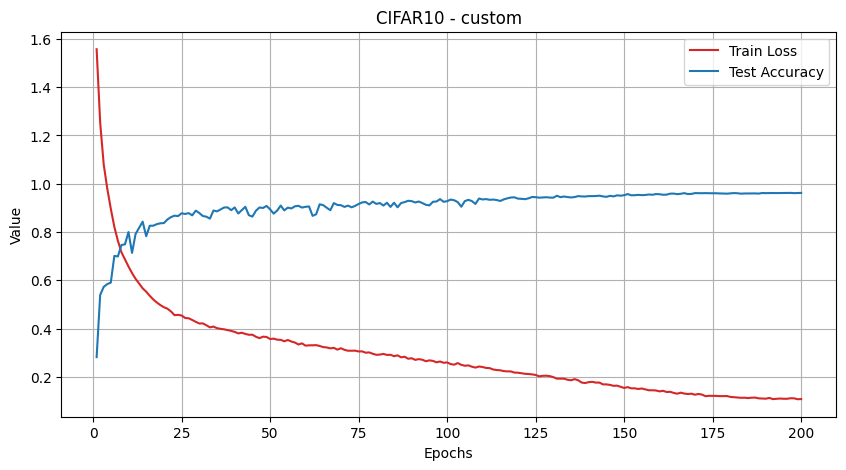

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='tab:red')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', color='tab:blue')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title(f'{DATASET_NAME} - {DATASET_TYPE}')
plt.legend()
plt.grid(True)
plt.show()

## Evaluate the model on Testset

In [13]:
import torch
import numpy as np

# Evaluate the CIFAR-10 dataset
correct = 0
total = 0

with torch.no_grad():
    net.eval()
    for images, labels in baseline_testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    if total == 0:
        print('No images found for CIFAR-10 dataset.')
    else:
        cifar10_accuracy = 100 * correct / total
        print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')

if not tpu:
    # Clear GPU memory
    torch.cuda.empty_cache()

    # Clear CPU memory
    torch.cuda.ipc_collect()

# Define the list of corruptions
corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
               'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
               'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
               'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# Define the batch size
batch_size = 256 

# Create an empty dictionary to store corrupted datasets
corrupted_datasets = {}

# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# List to store average accuracies for each corruption dataset
average_accuracies = []

# Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
for corruption in corruptions:
    print(f"Testing on corruption: {corruption}")

    # Load and test datasets for all 5 severity levels of the current corruption
    try:
        if DATASET_NAME=='CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
        elif DATASET_NAME=='CIFAR100':
            np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
        else:
            raise ValueError(f'Corruption dataset {DATASET_NAME} not loaded')
            
        np_data_c_splits = np.array_split(np_data_c, 5)
        
        # List to store accuracies of all severity levels for averaging
        accuracies = []

        for i, np_data_c_split in enumerate(np_data_c_splits):
            custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

            # Testing loop for the current corruption dataset split
            correct = 0
            total = 0

            with torch.no_grad():
                images_loaded = 0  # Counter for images loaded for the current corruption
                for images, labels in custom_dataloader:
                    images_loaded += len(images)  # Increment the counter by the number of images loaded
                    images, labels = images.to(device), labels.to(device)
                    # Calculate outputs by running images through the network
                    outputs = net(images)
                    # The class with the highest energy is chosen as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                if total == 0:
                    print(f'No images found for {corruption} dataset split {i+1}.')
                else:
                    accuracy = 100 * correct / total
                    print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
                    accuracies.append(accuracy)

                # Print the number of images loaded for the current corruption dataset split
                #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
                if not tpu:
                    # Clear GPU memory
                    torch.cuda.empty_cache()
                    # Clear CPU memory
                    torch.cuda.ipc_collect()

                # Delete variables to free up memory
                del custom_dataset
                del custom_dataloader

        # Calculate and print the average accuracy for the corruption dataset
        if accuracies:
            average_accuracy = sum(accuracies) / len(accuracies)
            average_accuracies.append(average_accuracy)
            print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

    except FileNotFoundError:
        print(f'Corruption {corruption} dataset not found.')
        continue

# Calculate and print the average robust accuracy
if average_accuracies:
    average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
    print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
else:
    print("No corrupt datasets found for evaluation.")

Accuracy of the network on the CIFAR-10 test dataset: 96.21 %
Testing on corruption: gaussian_noise


Accuracy of the network on gaussian_noise dataset split 1: 87.72 %


Accuracy of the network on gaussian_noise dataset split 2: 76.96 %


Accuracy of the network on gaussian_noise dataset split 3: 63.41 %


Accuracy of the network on gaussian_noise dataset split 4: 56.78 %


Accuracy of the network on gaussian_noise dataset split 5: 50.12 %
Average accuracy for gaussian_noise dataset: 67.00 %
Testing on corruption: shot_noise


Accuracy of the network on shot_noise dataset split 1: 91.43 %


Accuracy of the network on shot_noise dataset split 2: 86.96 %


Accuracy of the network on shot_noise dataset split 3: 73.78 %


Accuracy of the network on shot_noise dataset split 4: 67.24 %


Accuracy of the network on shot_noise dataset split 5: 56.71 %
Average accuracy for shot_noise dataset: 75.22 %
Testing on corruption: impulse_noise


Accuracy of the network on impulse_noise dataset split 1: 94.32 %


Accuracy of the network on impulse_noise dataset split 2: 91.31 %


Accuracy of the network on impulse_noise dataset split 3: 86.93 %


Accuracy of the network on impulse_noise dataset split 4: 71.26 %


Accuracy of the network on impulse_noise dataset split 5: 50.92 %
Average accuracy for impulse_noise dataset: 78.95 %
Testing on corruption: defocus_blur


Accuracy of the network on defocus_blur dataset split 1: 96.03 %


Accuracy of the network on defocus_blur dataset split 2: 95.68 %


Accuracy of the network on defocus_blur dataset split 3: 94.63 %


Accuracy of the network on defocus_blur dataset split 4: 92.44 %


Accuracy of the network on defocus_blur dataset split 5: 87.75 %
Average accuracy for defocus_blur dataset: 93.31 %
Testing on corruption: glass_blur


Accuracy of the network on glass_blur dataset split 1: 85.14 %


Accuracy of the network on glass_blur dataset split 2: 85.68 %


Accuracy of the network on glass_blur dataset split 3: 86.32 %


Accuracy of the network on glass_blur dataset split 4: 73.28 %


Accuracy of the network on glass_blur dataset split 5: 75.35 %
Average accuracy for glass_blur dataset: 81.15 %
Testing on corruption: motion_blur


Accuracy of the network on motion_blur dataset split 1: 94.59 %


Accuracy of the network on motion_blur dataset split 2: 91.79 %


Accuracy of the network on motion_blur dataset split 3: 87.59 %


Accuracy of the network on motion_blur dataset split 4: 87.70 %


Accuracy of the network on motion_blur dataset split 5: 83.03 %
Average accuracy for motion_blur dataset: 88.94 %
Testing on corruption: zoom_blur


Accuracy of the network on zoom_blur dataset split 1: 94.49 %


Accuracy of the network on zoom_blur dataset split 2: 94.27 %


Accuracy of the network on zoom_blur dataset split 3: 93.14 %


Accuracy of the network on zoom_blur dataset split 4: 91.85 %


Accuracy of the network on zoom_blur dataset split 5: 89.32 %
Average accuracy for zoom_blur dataset: 92.61 %
Testing on corruption: snow


Accuracy of the network on snow dataset split 1: 94.34 %


Accuracy of the network on snow dataset split 2: 90.94 %


Accuracy of the network on snow dataset split 3: 90.22 %


Accuracy of the network on snow dataset split 4: 88.42 %


Accuracy of the network on snow dataset split 5: 85.70 %
Average accuracy for snow dataset: 89.92 %
Testing on corruption: frost


Accuracy of the network on frost dataset split 1: 94.25 %


Accuracy of the network on frost dataset split 2: 91.98 %


Accuracy of the network on frost dataset split 3: 86.86 %


Accuracy of the network on frost dataset split 4: 86.52 %


Accuracy of the network on frost dataset split 5: 80.37 %
Average accuracy for frost dataset: 88.00 %
Testing on corruption: fog


Accuracy of the network on fog dataset split 1: 96.07 %


Accuracy of the network on fog dataset split 2: 95.57 %


Accuracy of the network on fog dataset split 3: 94.93 %


Accuracy of the network on fog dataset split 4: 93.40 %


Accuracy of the network on fog dataset split 5: 82.87 %
Average accuracy for fog dataset: 92.57 %
Testing on corruption: brightness


Accuracy of the network on brightness dataset split 1: 96.05 %


Accuracy of the network on brightness dataset split 2: 95.92 %


Accuracy of the network on brightness dataset split 3: 95.60 %


Accuracy of the network on brightness dataset split 4: 95.40 %


Accuracy of the network on brightness dataset split 5: 94.69 %
Average accuracy for brightness dataset: 95.53 %
Testing on corruption: contrast


Accuracy of the network on contrast dataset split 1: 95.97 %


Accuracy of the network on contrast dataset split 2: 95.34 %


Accuracy of the network on contrast dataset split 3: 94.82 %


Accuracy of the network on contrast dataset split 4: 93.68 %


Accuracy of the network on contrast dataset split 5: 89.48 %
Average accuracy for contrast dataset: 93.86 %
Testing on corruption: elastic_transform


Accuracy of the network on elastic_transform dataset split 1: 94.03 %


Accuracy of the network on elastic_transform dataset split 2: 94.35 %


Accuracy of the network on elastic_transform dataset split 3: 93.30 %


Accuracy of the network on elastic_transform dataset split 4: 88.64 %


Accuracy of the network on elastic_transform dataset split 5: 82.11 %
Average accuracy for elastic_transform dataset: 90.49 %
Testing on corruption: pixelate


Accuracy of the network on pixelate dataset split 1: 94.99 %


Accuracy of the network on pixelate dataset split 2: 90.53 %


Accuracy of the network on pixelate dataset split 3: 85.45 %


Accuracy of the network on pixelate dataset split 4: 62.89 %


Accuracy of the network on pixelate dataset split 5: 42.94 %
Average accuracy for pixelate dataset: 75.36 %
Testing on corruption: jpeg_compression


Accuracy of the network on jpeg_compression dataset split 1: 90.21 %


Accuracy of the network on jpeg_compression dataset split 2: 85.37 %


Accuracy of the network on jpeg_compression dataset split 3: 83.61 %


Accuracy of the network on jpeg_compression dataset split 4: 80.82 %


Accuracy of the network on jpeg_compression dataset split 5: 77.01 %
Average accuracy for jpeg_compression dataset: 83.40 %
Testing on corruption: speckle_noise


Accuracy of the network on speckle_noise dataset split 1: 91.46 %


Accuracy of the network on speckle_noise dataset split 2: 85.08 %


Accuracy of the network on speckle_noise dataset split 3: 80.85 %


Accuracy of the network on speckle_noise dataset split 4: 70.49 %


Accuracy of the network on speckle_noise dataset split 5: 60.10 %
Average accuracy for speckle_noise dataset: 77.60 %
Testing on corruption: gaussian_blur


Accuracy of the network on gaussian_blur dataset split 1: 96.05 %


Accuracy of the network on gaussian_blur dataset split 2: 94.59 %


Accuracy of the network on gaussian_blur dataset split 3: 93.28 %


Accuracy of the network on gaussian_blur dataset split 4: 91.15 %


Accuracy of the network on gaussian_blur dataset split 5: 85.52 %
Average accuracy for gaussian_blur dataset: 92.12 %
Testing on corruption: spatter


Accuracy of the network on spatter dataset split 1: 95.38 %


Accuracy of the network on spatter dataset split 2: 93.36 %


Accuracy of the network on spatter dataset split 3: 90.42 %


Accuracy of the network on spatter dataset split 4: 93.67 %


Accuracy of the network on spatter dataset split 5: 90.17 %
Average accuracy for spatter dataset: 92.60 %
Testing on corruption: saturate


Accuracy of the network on saturate dataset split 1: 94.94 %


Accuracy of the network on saturate dataset split 2: 93.05 %


Accuracy of the network on saturate dataset split 3: 95.80 %


Accuracy of the network on saturate dataset split 4: 94.82 %


Accuracy of the network on saturate dataset split 5: 93.58 %
Average accuracy for saturate dataset: 94.44 %
Average Robust Accuracy: 86.48 %


In [14]:
# # Load the model checkpoint
# net = WideResNet_28_4(num_classes=num_classes)
# checkpoint_path = '/kaggle/working/MasterArbeit/models/CIFAR10_net_ta_custom_100.pth'
# checkpoint = torch.load(checkpoint_path)
# net.load_state_dict(checkpoint, strict=False)
# net.to(device)

# import torch
# import numpy as np


# # Evaluate the CIFAR-10 dataset
# correct = 0
# total = 0

# with torch.no_grad():
#     net.eval()
#     for images, labels in baseline_testloader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     if total == 0:
#         print('No images found for CIFAR-10 dataset.')
#     else:
#         cifar10_accuracy = 100 * correct / total
#         print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')
        
# if not tpu:
#     # Clear GPU memory
#     torch.cuda.empty_cache()

#     # Clear CPU memory
#     torch.cuda.ipc_collect()

# # Define the list of corruptions
# corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
#                'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
#                'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
#                'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# # Define the batch size
# batch_size = 256 

# # Create an empty dictionary to store corrupted datasets
# corrupted_datasets = {}

# # Prepare to count predictions for each class
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# # List to store average accuracies for each corruption dataset
# average_accuracies = []

# # Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
# for corruption in corruptions:
#     print(f"Testing on corruption: {corruption}")

#     # Load and test datasets for all 5 severity levels of the current corruption
#     try:
#         if DATASET_NAME=='CIFAR10':
#             np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
#         elif DATASET_NAME=='CIFAR100':
#             np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
#         else:
#             raise ValueError(f'Corruption dataset {DATASET_NAME} not loaded')
#         np_data_c_splits = np.array_split(np_data_c, 5)
        
#         # List to store accuracies of all severity levels for averaging
#         accuracies = []

#         for i, np_data_c_split in enumerate(np_data_c_splits):
#             custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
#             custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

#             # Testing loop for the current corruption dataset split
#             correct = 0
#             total = 0

#             with torch.no_grad():
#                 images_loaded = 0  # Counter for images loaded for the current corruption
#                 for images, labels in custom_dataloader:
#                     images_loaded += len(images)  # Increment the counter by the number of images loaded
#                     images, labels = images.to(device), labels.to(device)
#                     # Calculate outputs by running images through the network
#                     outputs = net(images)
#                     # The class with the highest energy is chosen as prediction
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#                 if total == 0:
#                     print(f'No images found for {corruption} dataset split {i+1}.')
#                 else:
#                     accuracy = 100 * correct / total
#                     print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
#                     accuracies.append(accuracy)

#                 # Print the number of images loaded for the current corruption dataset split
#                 #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
#                 if not tpu:
#                     # Clear GPU memory
#                     torch.cuda.empty_cache()
#                     # Clear CPU memory
#                     torch.cuda.ipc_collect()

#                 # Delete variables to free up memory
#                 del custom_dataset
#                 del custom_dataloader

#         # Calculate and print the average accuracy for the corruption dataset
#         if accuracies:
#             average_accuracy = sum(accuracies) / len(accuracies)
#             average_accuracies.append(average_accuracy)
#             print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

#     except FileNotFoundError:
#         print(f'Corruption {corruption} dataset not found.')
#         continue

# # Calculate and print the average robust accuracy
# if average_accuracies:
#     average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
#     print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
# else:
#     print("No corrupt datasets found for evaluation.")